# Findings from TMDB movies

#### Importing relevant libraries and the dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

dataset = "TMDB_movies.csv"
df = pd.read_csv(dataset)

<div style="display: flex; align-items: center;">
  <div style="flex: 1;">
    <p style="font-size: 1.2em; font-weight: bold;">
      Released in 2025, Superman had a budget of 225 million dollars, and is set to break 750 million in revenue, meaning an almost 300% profit. So this had me wondering...
    </p>
  </div>
  <div style="flex: 1; text-align: right;">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/3/32/Superman_%282025_film%29_poster.jpg/250px-Superman_%282025_film%29_poster.jpg" alt="Superman Poster" width="300"/>
  </div>
</div>

src: wikipedia


<div style="display: flex; align-items: center;">
  <div style="flex: 1;">
    <p style="font-size: 1.2em; font-weight: bold;">
      Do the blockbusters actually provide the best return on investment? <br>
        Does profit % scale with the budget of the film?  
    </p>
  </div>
  <div style="flex: 1; padding-left: 400px;">
    <img src="https://thumbs.dreamstime.com/b/growing-savings-concept-money-bag-sprouting-leaves-next-to-coin-pile-green-nature-backdrop-image-features-sack-375417346.jpg" alt="Profit growth" width="300" style="margin-left: auto;"/>
  </div>
</div>
src: dreamstime.com

<h6>Code to amend data accordingly</h6>
    * Cleaned to remove all nulled, 0 values, and outliers

In [2]:
# Add a new column that is the profit %
df['percent_profit'] = ((df['revenue'] - df['budget']) / df['budget']) * 100

# Remove rows with 0 revenue or budget below 7000
df_clean = df[(df['revenue'] != 0) & (df['budget'] >= 7000)].copy()

# Remove NaNs and 'inf' from percent_profit
df_clean = df_clean[df_clean['percent_profit'].notna() & df_clean['percent_profit'].apply(lambda x: x != float('inf'))].copy()

# Round profit to 2 decimal places
df_clean['percent_profit'] = df_clean['percent_profit'].round(2)

# Create view of only columns I want
condensed = df_clean[['title', 'budget', 'genres', 'popularity',
                      'revenue', 'vote_average', 'vote_count', 'percent_profit']]
#Remove the two highest profit makers
highest_profit_outliers = ['Paranormal Activity', 'The Blair Witch Project'] 
outliers_df = condensed[condensed['title'].isin(highest_profit_outliers)].copy()
condensed = condensed[~condensed['title'].isin(highest_profit_outliers)].copy()


### Correlation between Budget and Profit %

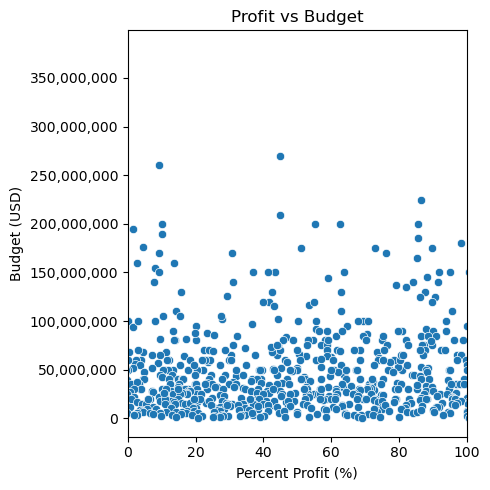

In [3]:
plt.figure(figsize=(5, 5))
sns.scatterplot(data=condensed, x='percent_profit', y='budget')

# Format axes with commas
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{int(y):,}'))

#Limits the x axis to 100% profit
plt.xlim(0, 100)

plt.xlabel('Percent Profit (%)')
plt.ylabel('Budget (USD)')
plt.title('Profit vs Budget')
plt.tight_layout()
plt.show()



#### From this rather sporadic looking data, we can see that there is no correlation to be drawn between budget and profit, which is confirmed by...

<h5> Our Pearson Correlation</h5>

In [4]:
condensed['budget'].corr(condensed['percent_profit'])


np.float64(-0.10409860321002534)

This figure of -0.104 shows that there is actually a <b>very slight <u>negative correlation</u></b> between budget and profit. Meaning there is definitely no guarantee that spending more on a film will return more profits.

### So, if budget has no impact on the profit a film makes, surely one of our other metrics will have some correlation with profit?

Do 

* popularity
* revenue
* vote average (average review score)
* vote count (amount of reviews)

have any bearing on it?

In [5]:
condensed.corr(numeric_only=True)[['percent_profit']]


,percent_profit
budget,-0.104099
popularity,0.029456
revenue,0.033980
vote_average,0.078601
vote_count,0.028960
percent_profit,1.000000


### Rather anticlimatically... no, in actual fact, none of our metrics show to have any correlation with profit

<img src='https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExOG5iOTRsM3Jnamgwc3lxcHEzaWJ2YTh5NXI4eWJjanU2MjhrbjFqNCZlcD12MV9naWZzX3NlYXJjaCZjdD1n/FLo0LIBIUeI6c/giphy.gif'>

### So... what _do_ the most profitable films have in common? 
#### I decided to do a deeper dive into the top 20

In [6]:
# top 20 films by profit %
top_20_profit = df_clean.sort_values('percent_profit', ascending=False).head(20)


In [7]:
# Function to extract the genres into a new columns - src: Tim Frith
import ast
def extract_genres(x):
    ''' Function to extract genres for each datapoint. '''
    x = ast.literal_eval(x) ## Transform '['name', 'id']' back into ['name', 'id']
    Genres = [] ## Empty list to store the genres
    
    # Iterate through each dictionary
    for item in x: ## iterate for each dictionary in our list
        Genres.append(item['name']) ## Grab the 'name' key for each dictionary
        
    # Return the Genres
    return Genres
## Apply the function to genres
top_20_profit['extracted_genres'] = top_20_profit['genres'].apply(extract_genres)
#Expand the genres into their own rows
exploded = top_20_profit.explode('extracted_genres')

### Firstly, which genres are most frequent across the top 20?
#### Bar-Chart showing the most frequent genres across the 20 most profitable films

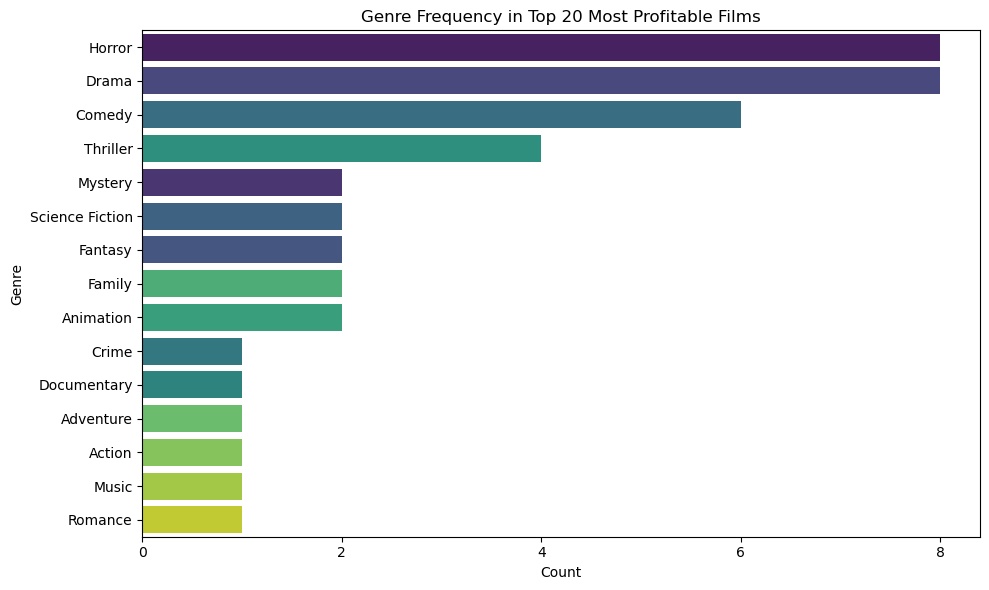

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=exploded, y='extracted_genres',
              order=exploded['extracted_genres'].value_counts().index,
              palette='viridis', hue='extracted_genres')

max_count = exploded['extracted_genres'].value_counts().max()
plt.xticks(np.arange(0, max_count + 1, 2)) # This adjusts the x axis values (start, stop, step)

plt.title('Genre Frequency in Top 20 Most Profitable Films')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

You can see here that **Drama and Horror** are far more likely to be profitable than other genres.


### Secondly, what are the typical budgets of these top 20 profitable films?

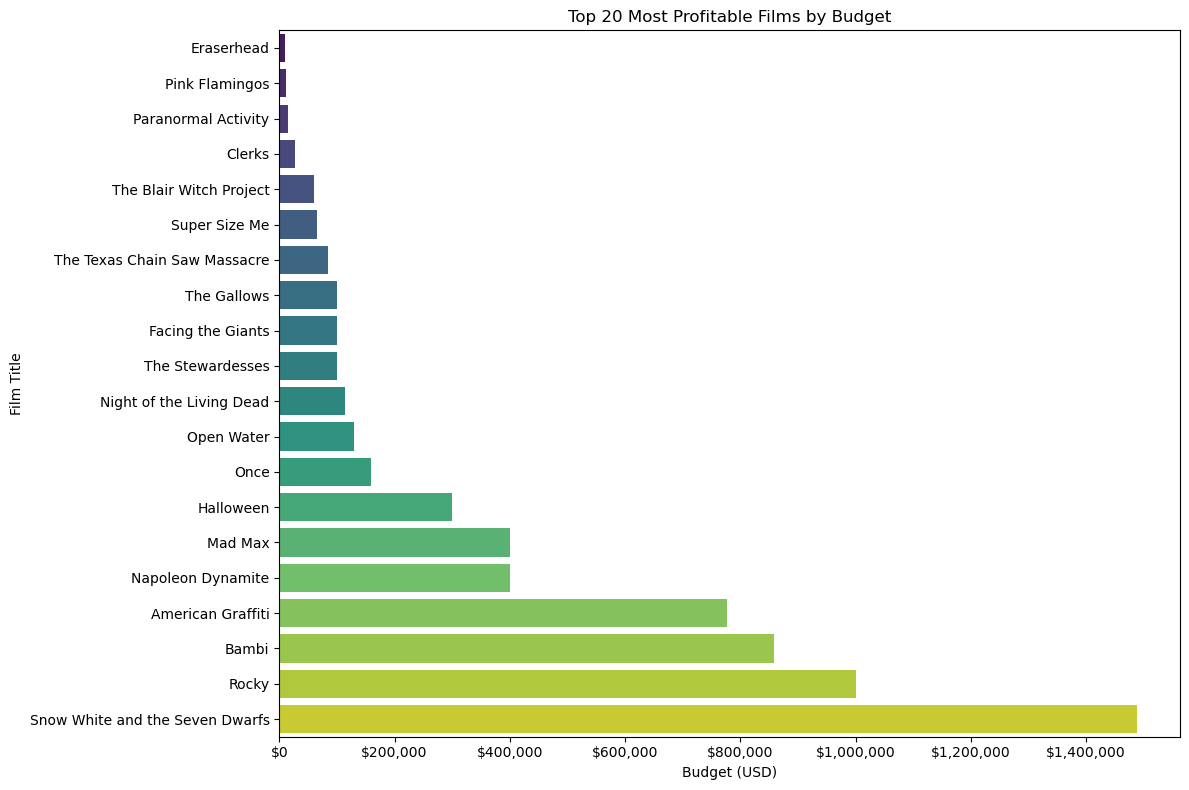

In [9]:
top_20_sorted = top_20_profit.sort_values('budget', ascending=True)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_20_sorted,
    x='budget',
    y='title',
    palette='viridis',
    hue = 'title'
)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${int(x):,}'))


plt.title('Top 20 Most Profitable Films by Budget')
plt.xlabel('Budget (USD)')
plt.ylabel('Film Title')
plt.tight_layout()
plt.show()

#### We can see here that all of the top 20 have a budget of less than `$1.5m`, and in fact, the majority actually have a budget of less than `$100k`

<h5><u>This shows that having a bigger budget is actually less likely to lead to a greater profit margin</u></h5>

#### What about the most common keywords across the top 20?

Each film has a list of keywords that typically summarise the theme, plot subject and type of film, if we look at the most common among the top 20 we see that:

In [10]:
def extract_keywords(x):
    try:
        parsed = ast.literal_eval(x)
        return [item['name'] for item in parsed if 'name' in item]
    except (ValueError, SyntaxError, TypeError):
        return []

top_20_profit['extracted_keywords'] = top_20_profit['keywords'].apply(extract_keywords)
exploded_keywords = top_20_profit.explode('extracted_keywords')
display(exploded_keywords['extracted_keywords'].value_counts().head(2).reset_index().rename(columns={'index': 'Keyword', 'extracted_keywords': 'Count'}))


,Count,count
0,independent film,4
1,found footage,3


Independent and Found Footage Films are the most frequent among the top 20, this checks out as these typically have very low budgets due to having a minimal cast and less set design.

### So... what have we gleaned from this?
For maximum profit margins, the films most likely to deliver should;

* Be Horror or Drama Films 
* Have a budget of less than 100k
* Be in English
* Have a run-time of approx 90 mins

Below is a summary table of the top 20's key data

In [11]:
summary_20 = top_20_profit[['title', 'extracted_genres','original_language','release_date','runtime','budget','revenue','percent_profit']]
summary_20

,title,extracted_genres,original_language,release_date,runtime,budget,revenue,percent_profit
4577,Paranormal Activity,"[Horror, Mystery]",en,2007-09-14,86.0,15000,193355800,1288938.67
4496,The Blair Witch Project,"[Horror, Mystery]",en,1999-07-14,81.0,60000,248000000,413233.33
4724,Eraserhead,"[Drama, Fantasy, Horror, Science Fiction]",en,1977-03-19,89.0,10000,7000000,69900.00
4788,Pink Flamingos,"[Horror, Comedy, Crime]",en,1972-03-12,93.0,12000,6000000,49900.00
4742,Super Size Me,"[Documentary, Comedy, Drama]",en,2004-01-17,100.0,65000,28575078,43861.66
4723,The Gallows,"[Horror, Thriller]",en,2015-07-10,87.0,100000,42664410,42564.41
4514,Open Water,"[Drama, Thriller]",en,2004-08-06,79.0,130000,54667954,41952.27
3159,The Texas Chain Saw Massacre,[Horror],en,1974-10-01,83.0,85000,30859000,36204.71
4441,Bambi,"[Animation, Drama, Family]",en,1942-08-14,70.0,858000,267447150,31071.00
4668,The Stewardesses,[Comedy],en,1969-07-25,69.0,100000,27000000,26900.00


<div style="display: flex; align-items: center;">
  <div style="flex: 1;">
    <p style="font-size: 1.2em; font-weight: bold;">
      Paranormal Activity, what made it so profitable?
    </p>
      <p>
      I've chosen this film as it is our most profitable film, and wanted to investigate what contributed to this.
    </p>
        <p>
      We can see from our database that the horror genre was becoming increasingly popular, with horror film production on an upwards trend through the 2000s up to 2007, when Paranormal Activity was released.
    </p>
  </div>
  <div style="flex: 1; text-align: right;">
    <img src="PA.jpeg" width="300"/>
  </div>
</div>

src: wikipedia


In [12]:
summary_20.head(1)

,title,extracted_genres,original_language,release_date,runtime,budget,revenue,percent_profit
4577,Paranormal Activity,"[Horror, Mystery]",en,2007-09-14,86.0,15000,193355800,1288938.67


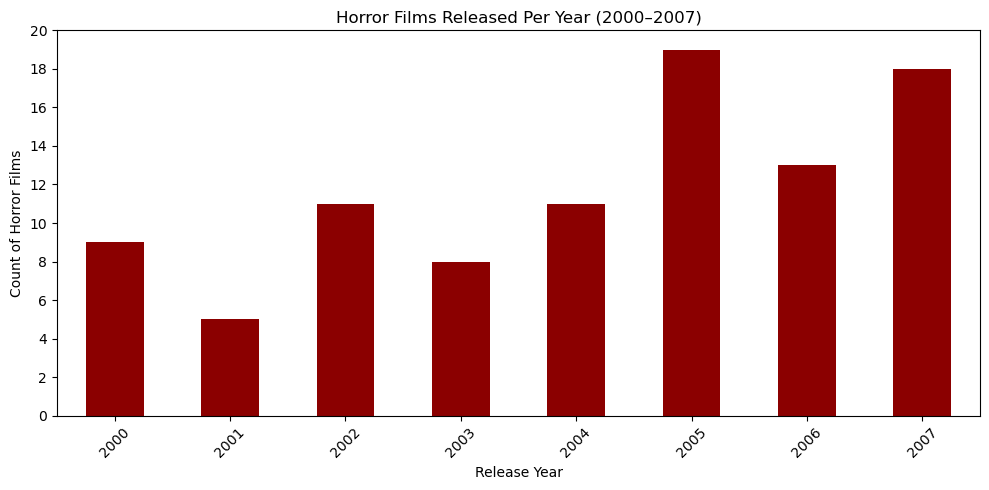

In [13]:

df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date'].dt.year.astype('Int64')

# Pick out horror films
def is_horror(x):
    if isinstance(x, str):
        try:
            genres = ast.literal_eval(x)
            if isinstance(genres, list):
                return any(g.get('name') == 'Horror' for g in genres if isinstance(g, dict))
        except:
            return False
    return False

df_clean['is_horror'] = df_clean['genres'].apply(is_horror)

# Filter for years 2000 to 2007
horror_counts = (
    df_clean[(df_clean['is_horror']) & (df_clean['release_year'].between(2000, 2007))]
    .groupby('release_year')
    .size()
)

# Plot
plt.figure(figsize=(10, 5))
horror_counts.plot(kind='bar', color='darkred')
plt.title('Horror Films Released Per Year (2000–2007)')
plt.xlabel('Release Year')
plt.ylabel('Count of Horror Films')
plt.yticks(np.arange(0, horror_counts.max() + 2, 2))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Our database is limited on being able to suggest reasons why a film is particularly profitable, so I did some outside research:

### Further contributing factors to Paranormal Activity's success:

* The Director actually filmed it in his own house - saving huge expense
* Didn't use professional actors
* Limited release, and allowed word of mouth via social media to do the advertising for them.

<div style="display: flex; align-items: center;">
  <div style="flex: 1;">
    <p style="font-size: 1.2em; font-weight: bold;">
      Snow White and the Seven Dwarves, why was it so profitable?
    </p>
  </div>
  <div style="flex: 1; text-align: right;">
    <img src="SW.jpeg" style="padding-left: 400px;" />
  </div>
</div>

src: wikipedia

I've chosen this as it was the earliest release from our top 20 list, so wanted to investigate why it fares so well.

In [14]:
summary_20[summary_20['title'] == 'Snow White and the Seven Dwarfs']

,title,extracted_genres,original_language,release_date,runtime,budget,revenue,percent_profit
4259,Snow White and the Seven Dwarfs,"[Fantasy, Animation, Family]",en,1937-12-20,83.0,1488423,184925486,12324.26


#### Bar Chart showing number of films per year 1920-1940

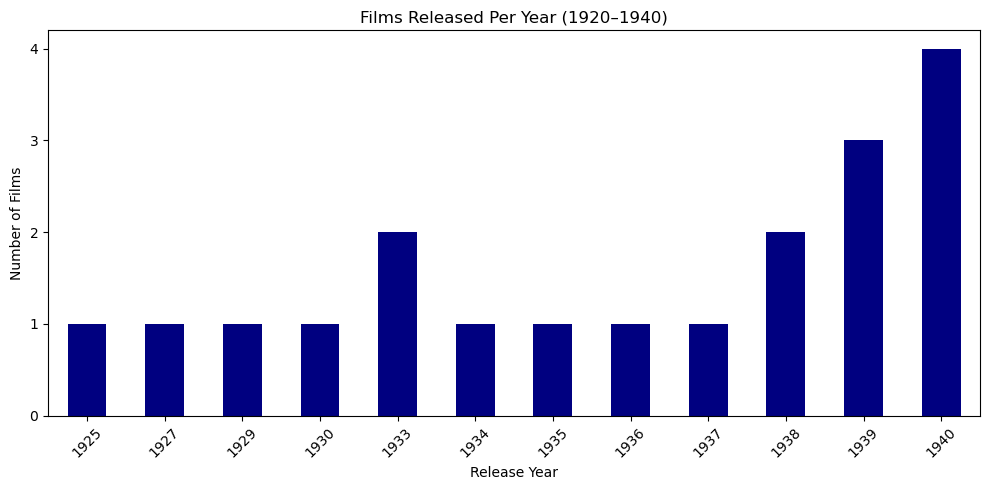

In [15]:
df_clean['release_date'] = pd.to_datetime(df_clean['release_date'], errors='coerce')
df_clean['release_year'] = df_clean['release_date'].dt.year.astype('Int64')

# Filter 1920 to 1940 
early_counts = (
    df_clean[df_clean['release_year'].between(1920, 1940)]
    .groupby('release_year')
    .size()
)

# Plot
plt.figure(figsize=(10, 5))
early_counts.plot(kind='bar', color='navy')
plt.title('Films Released Per Year (1920–1940)')
plt.xlabel('Release Year')
plt.ylabel('Number of Films')
plt.yticks(range(0, early_counts.max() + 1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<b>From our data, we can see that far fewer films were made in the years around release, meaning a lot less competition for viewers.</b>

Further contributing factors:

*  It was the first ever full-feature colour animated film, garnering enormous public anticipation
*  Disney launched a huge merchandising campaign pre-release, turning Snow White into a brand
*  It has been re-released multiple times since, contributing to its revenue figures

#### Conclusion

* Budget has no correlation with profit, and a bigger budget does not mean more profit
* Profit margins actually have no correlation with any table metric (popularity, average review etc)
* The most profitable films are usually Horrors or Dramas, with small budgets, made in English
* Films that were unique at time of release, or were one of the first to do a particular theme/genre also produced the biggest profit margin.